<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plan" data-toc-modified-id="Plan-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plan</a></span></li><li><span><a href="#CIFAR-data" data-toc-modified-id="CIFAR-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CIFAR data</a></span></li><li><span><a href="#Play-with-conv-dimensions" data-toc-modified-id="Play-with-conv-dimensions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Play with conv dimensions</a></span></li><li><span><a href="#Net-Implementaton" data-toc-modified-id="Net-Implementaton-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Net Implementaton</a></span></li><li><span><a href="#Net-Training" data-toc-modified-id="Net-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Net Training</a></span></li></ul></div>

### Plan 
1. Image classification net - simple / well known
    - full circle Implement/Train [tr/val]
2. Preprocessing / augmenttations
3. Different Activation Units
4. Batch normalization
5. Dropout
6. Different optimizations SGD/Adam etc,
7. Check num of params FLOPS etc.
8. Visualization

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.functional import  F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

sns.set_style("white")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### CIFAR data

In [3]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imgshow(img, w=64, h=4):
    img = img.numpy()
    img = np.transpose(img,  axes=(1, 2, 0))
    plt.imshow(img)
    ax = plt.gca()
    fig = plt.gcf()
    plt.axis('off')
    fig.set_size_inches((w, h))

In [4]:
data_path = "/home/cortica/Documents/my/fa/data/cifar"
batch_size = 1024
transform = transforms.Compose(
    [transforms.ToTensor(),
    ])

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/cortica/Documents/my/fa/data/cifar
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [6]:
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# img_grid = torchvision.utils.make_grid(images)
# imgshow(img_grid)

### Play with conv dimensions

In [7]:
x = torch.randn(1, 3, 32, 32)

In [8]:
conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
pool1 = nn.AdaptiveMaxPool2d((8, 8))
conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
pool2 = nn.AdaptiveMaxPool2d((3, 3))
fc = nn.Linear(in_features=64 * 3 * 3, out_features=128)
fc

Linear(in_features=576, out_features=128, bias=True)

In [124]:
convolved1 = conv1(x)
convolved1.shape

torch.Size([1, 64, 16, 16])

In [125]:
pooled1 = pool1(convolved1)
pooled1.shape

torch.Size([1, 64, 8, 8])

In [126]:
convolved2 = conv2(pooled1)
convolved2.shape

torch.Size([1, 64, 8, 8])

In [127]:
pooled2 = pool2(convolved2)
pooled2.shape

torch.Size([1, 64, 3, 3])

In [ ]:
nn.Linear()

### Net Implementaton

In [10]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1, )
        self.pool1 = nn.AdaptiveMaxPool2d((8, 8))
        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.pool2 = nn.AdaptiveMaxPool2d((4, 4))
        self.fc1 = nn.Linear(in_features=64 * 4 * 4, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def train_net(train, test, net, lr, epochs=10):
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    cross_entropy = nn.CrossEntropyLoss()
    losses_train, losses_test = [], []
    for epoch in range(epochs):

        for b_id, batch in enumerate(train):
            optimizer.zero_grad()

            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = net(x_batch)
            loss_var = cross_entropy(logits, y_batch)
            loss_var.backward()
            optimizer.step()

            loss_train_batch = loss_var.item()
            losses_train.append(loss_train_batch)
            
            test_loss = -1 # apply_net_test(test, net, cross_entropy)
            losses_test.append(test_loss)
            
            acc_train_batch = accuracy_from_logits(logits, y_batch)
            if b_id % 10 == 0:
                print("[{:3d}ep {:2d}bch] - train_loss:{:2.3f}| acc:{:2.2f} || test_loss:{:2.3f}".format(epoch, b_id, loss_train_batch, acc_train_batch, test_loss))
            
            del loss_var 

    return losses_train, losses_test

def apply_net_test(test, net, cross_entropy):
    losses = []
    for x, y in test:
        x, y = x.to(device), y.to(device)
        logits = net(x)
        loss_var = cross_entropy(logits, y)
        loss = loss_var.item()
        losses.append(loss)
        del loss_var
        # accu = accuracy_from_logits(logits, y)
    return np.mean(loss)

def accuracy_from_logits(predicted_logits, y_true):
    y_predicted = predicted_logits.argmax(dim=1)
    accuracy = accuracy_score(y_true.cpu(), y_predicted.cpu())
    return accuracy

### Net Training

In [12]:
lr = .1
epochs = 64
device = torch.device('cuda:0')
net = ConvNet()
net.to(device)
losses_train, losses_test =  train_net(trainloader, testloader, net, lr, epochs=epochs)

[  0ep  0bch] - train_loss:2.304| acc:0.12 || test_loss:-1.000
[  0ep 10bch] - train_loss:2.285| acc:0.12 || test_loss:-1.000
[  0ep 20bch] - train_loss:2.172| acc:0.20 || test_loss:-1.000
[  0ep 30bch] - train_loss:2.307| acc:0.08 || test_loss:-1.000
[  0ep 40bch] - train_loss:2.296| acc:0.20 || test_loss:-1.000
[  1ep  0bch] - train_loss:2.254| acc:0.20 || test_loss:-1.000
[  1ep 10bch] - train_loss:2.138| acc:0.20 || test_loss:-1.000
[  1ep 20bch] - train_loss:2.223| acc:0.16 || test_loss:-1.000
[  1ep 30bch] - train_loss:2.069| acc:0.21 || test_loss:-1.000
[  1ep 40bch] - train_loss:1.999| acc:0.29 || test_loss:-1.000
[  2ep  0bch] - train_loss:1.851| acc:0.35 || test_loss:-1.000
[  2ep 10bch] - train_loss:1.733| acc:0.36 || test_loss:-1.000
[  2ep 20bch] - train_loss:1.909| acc:0.30 || test_loss:-1.000
[  2ep 30bch] - train_loss:1.877| acc:0.31 || test_loss:-1.000
[  2ep 40bch] - train_loss:1.799| acc:0.34 || test_loss:-1.000
[  3ep  0bch] - train_loss:1.914| acc:0.32 || test_loss

[ 26ep 10bch] - train_loss:0.462| acc:0.83 || test_loss:-1.000
[ 26ep 20bch] - train_loss:0.506| acc:0.82 || test_loss:-1.000
[ 26ep 30bch] - train_loss:0.465| acc:0.82 || test_loss:-1.000
[ 26ep 40bch] - train_loss:0.586| acc:0.79 || test_loss:-1.000
[ 27ep  0bch] - train_loss:0.433| acc:0.85 || test_loss:-1.000
[ 27ep 10bch] - train_loss:0.405| acc:0.85 || test_loss:-1.000
[ 27ep 20bch] - train_loss:0.401| acc:0.85 || test_loss:-1.000
[ 27ep 30bch] - train_loss:0.442| acc:0.85 || test_loss:-1.000
[ 27ep 40bch] - train_loss:0.498| acc:0.82 || test_loss:-1.000
[ 28ep  0bch] - train_loss:0.410| acc:0.86 || test_loss:-1.000
[ 28ep 10bch] - train_loss:0.440| acc:0.84 || test_loss:-1.000
[ 28ep 20bch] - train_loss:0.479| acc:0.83 || test_loss:-1.000
[ 28ep 30bch] - train_loss:0.415| acc:0.85 || test_loss:-1.000
[ 28ep 40bch] - train_loss:0.466| acc:0.84 || test_loss:-1.000
[ 29ep  0bch] - train_loss:0.475| acc:0.82 || test_loss:-1.000
[ 29ep 10bch] - train_loss:0.437| acc:0.83 || test_loss

[ 52ep 20bch] - train_loss:0.197| acc:0.92 || test_loss:-1.000
[ 52ep 30bch] - train_loss:0.127| acc:0.96 || test_loss:-1.000
[ 52ep 40bch] - train_loss:0.196| acc:0.94 || test_loss:-1.000
[ 53ep  0bch] - train_loss:0.183| acc:0.93 || test_loss:-1.000
[ 53ep 10bch] - train_loss:0.191| acc:0.93 || test_loss:-1.000
[ 53ep 20bch] - train_loss:0.179| acc:0.93 || test_loss:-1.000
[ 53ep 30bch] - train_loss:0.152| acc:0.95 || test_loss:-1.000
[ 53ep 40bch] - train_loss:0.189| acc:0.92 || test_loss:-1.000
[ 54ep  0bch] - train_loss:0.230| acc:0.92 || test_loss:-1.000
[ 54ep 10bch] - train_loss:0.182| acc:0.93 || test_loss:-1.000
[ 54ep 20bch] - train_loss:0.248| acc:0.91 || test_loss:-1.000
[ 54ep 30bch] - train_loss:0.199| acc:0.93 || test_loss:-1.000
[ 54ep 40bch] - train_loss:0.265| acc:0.92 || test_loss:-1.000
[ 55ep  0bch] - train_loss:0.127| acc:0.96 || test_loss:-1.000
[ 55ep 10bch] - train_loss:0.140| acc:0.95 || test_loss:-1.000
[ 55ep 20bch] - train_loss:0.092| acc:0.97 || test_loss

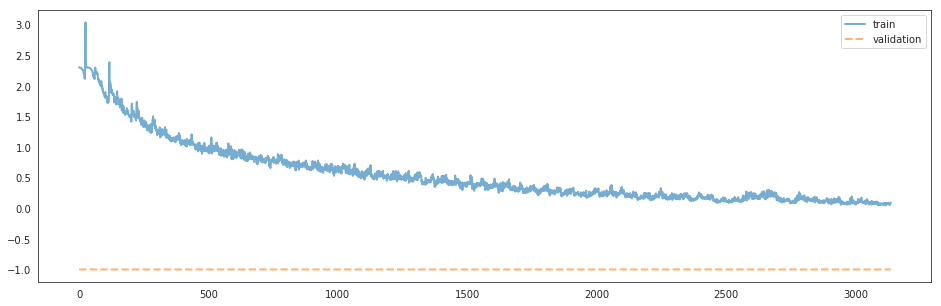

In [13]:
plt.plot(losses_train, ls="-", lw=2, alpha=.6, label="train")
plt.plot(losses_test, ls="--", lw=2, alpha=.6, label="validation")
f = plt.gcf()
f.set_size_inches((16, 5))
plt.legend()

In [15]:
params = net.parameters()
params_l = []
for i,p in enumerate(params):
    
    print(p.shape)
    params_l.append(p.detach().cpu())
    if i==1:
        print(p)

torch.Size([64, 3, 3, 3])
torch.Size([64])
Parameter containing:
tensor([ 1.1583, -0.1501, -0.0103, -0.0449, -0.3510,  1.3634, -1.2052,  0.3218,
        -0.4222, -0.1892, -0.1760,  1.8197, -0.2730, -0.5918, -0.3235,  0.8686,
        -0.0235, -0.2072, -0.1607, -0.0397,  1.2660,  0.3362,  0.4190, -2.0094,
        -0.2709, -0.1403, -0.9324,  0.0655,  0.0988, -0.2254, -0.4399, -0.0791,
        -0.4785,  0.0163, -0.0334, -0.1959, -0.1257,  0.4960, -0.1110, -0.0902,
        -0.0231,  0.0121,  0.1829, -0.0598, -0.6831, -0.0869, -0.3729, -0.1347,
         0.1233, -1.4064, -0.1540,  0.1612, -0.1326, -0.0190, -0.0297, -0.0046,
        -0.1427,  0.3753,  0.6469, -0.0404, -0.2295,  0.0150, -0.1445,  0.0229],
       device='cuda:0', requires_grad=True)
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 1024])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [16]:
layer1 = torchvision.utils.make_grid(params_l[0])
# layer1[layer1==0.0] = 1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


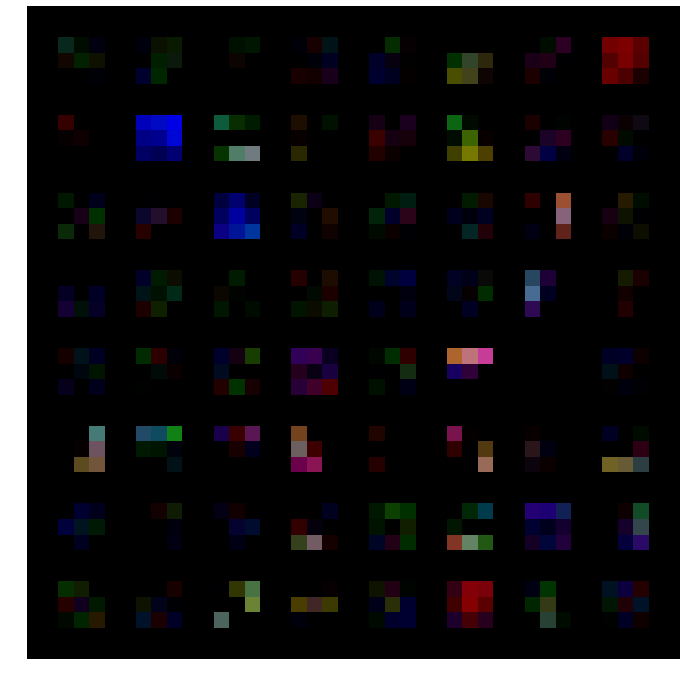

In [15]:
imgshow(layer1, 12, 12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


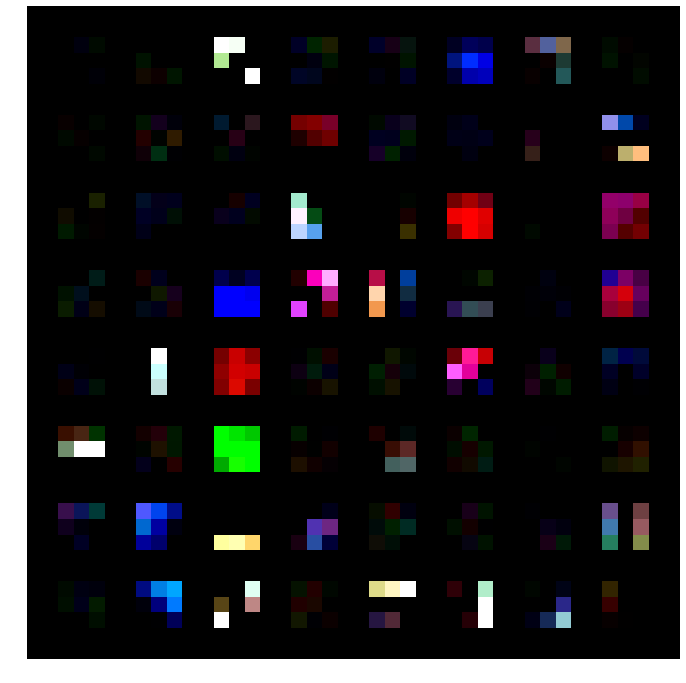

In [17]:
imgshow(layer1, 12, 12)